# Solving the Graphene Defect Problem with D-Wave (QA, simulated annealing, random sampling)

In [2]:
# -*- coding: utf-8 -*-
import sys
import os
import copy
import re

import numpy as np
import pandas as pd
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')
import matplotlib.pyplot as plt

from dwave.embedding.chain_strength import  uniform_torque_compensation
from dimod.binary import BinaryQuadraticModel
from dwave.system import EmbeddingComposite, DWaveSampler, LeapHybridSampler, DWaveCliqueSampler, AutoEmbeddingComposite, FixedEmbeddingComposite
# from dwave.system import LeapHybridSampler, LeapHybridCQMSampler, LeapHybridDQMSampler, LeapHybridNLSampler
from dwave.samplers import SimulatedAnnealingSampler
from dimod import RandomSampler

import dwave.inspector
from dwave.inspector.adapters import (
    from_qmi_response, from_bqm_response, from_bqm_sampleset, from_objects,
    enable_data_capture)

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.analysis.graphs import StructureGraph
from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter
from pymatgen.vis.structure_vtk import StructureVis
from pymatgen.vis import structure_vtk

from itertools import product
import time

timestr = time.strftime("%Y%m%d-%H%M%S")

from ase.visualize import view
from CRYSTALpytools.crystal_io import *
from CRYSTALpytools.convert import *
sys.path.insert(1,'../')
from quantum_computing_functions import *
from quantum_computing_postprocessing import *
from paper_functions import *


import warnings
warnings.filterwarnings('ignore')
np.seterr(divide='ignore')
plt.style.use('tableau-colorblind10')

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import copy
import numpy as np

import timeit

# enable inspector data capture on import!
enable_data_capture()

## Set options

In [3]:
# Select chosen method
device = 'Random' # 'Random', 'SA', 'Hybrid'

# Set number of vacancies (left at 3)
num_vacs = [3]
# Set the QUBO penalty term coefficient
lambdas = 2
# Set embedding technique for QA
embedding = 'minor' # 'clique'
# Set supercell size (which dictates QUBO size)
n_supercell = 4

# Set experimental repeats
repeats = 10

# Set chain strength
chain_strength_value = 12 
# Set annealing time
anneal_time = 2000# default is 20, n3 is 2000, n4 is 2000
# Set the temperature range for simulated annealing
beta_range = [0.1, 10] 
# Set the number of sweeps for simulated annealing
num_sweeps = 1000 # 1000
# Set the number of shots for QA
shots = 1000 
# Initialise embedding time as zero before 
TimeEmbed = 0

## The following two cells alter the source code of the D-wave embedding functions to add timers

In [4]:
import itertools

from warnings import warn

import dimod
import minorminer
import functools

from dwave.embedding import (target_to_source, unembed_sampleset, embed_bqm,
                             chain_to_quadratic, EmbeddedStructure)
from dwave.system.warnings import WarningHandler, WarningAction

# Declare the global variable
# TimeEmbed = None

__all__ = ('EmbeddingComposite',
           'FixedEmbeddingComposite',
           'LazyFixedEmbeddingComposite',
           'LazyEmbeddingComposite',  # deprecated
           'AutoEmbeddingComposite',
           )


class EmbeddingComposite(dimod.ComposedSampler):
    """Maps problems to a structured sampler.

    Automatically minor-embeds a problem into a structured sampler such as a
    D-Wave system. A new minor-embedding is calculated each time one of its
    sampling methods is called.

    Args:
        child_sampler (:class:`dimod.Sampler`):
            A dimod sampler, such as a :obj:`.DWaveSampler`, that accepts
            only binary quadratic models of a particular structure.

        find_embedding (function, optional):
            A function `find_embedding(S, T, **kwargs)` where `S` and `T`
            are edgelists. The function can accept additional keyword arguments.
            Defaults to :func:`minorminer.find_embedding`.

        embedding_parameters (dict, optional):
            If provided, parameters are passed to the embedding method as
            keyword arguments.

        scale_aware (bool, optional, default=False):
            Pass chain interactions to child samplers that accept an `ignored_interactions`
            parameter.

        child_structure_search (function, optional):
            A function `child_structure_search(sampler)` that accepts a sampler
            and returns the :attr:`dimod.Structured.structure`.
            Defaults to :func:`dimod.child_structure_dfs`.

    Examples:

       >>> from dwave.system import DWaveSampler, EmbeddingComposite
       ...
       >>> sampler = EmbeddingComposite(DWaveSampler())
       >>> h = {'a': -1., 'b': 2}
       >>> J = {('a', 'b'): 1.5}
       >>> sampleset = sampler.sample_ising(h, J, num_reads=100)
       >>> sampleset.first.energy
       -4.5


    """
    def __init__(self, child_sampler,
                 find_embedding=minorminer.find_embedding,
                 embedding_parameters=None,
                 scale_aware=False,
                 child_structure_search=dimod.child_structure_dfs):

        self.children = [child_sampler]

        # keep any embedding parameters around until later, because we might
        # want to overwrite them
        self.embedding_parameters = embedding_parameters or {}
        self.find_embedding = find_embedding

        # set the parameters
        self.parameters = parameters = child_sampler.parameters.copy()
        parameters.update(chain_strength=[],
                          chain_break_method=[],
                          chain_break_fraction=[],
                          embedding_parameters=[],
                          return_embedding=[],
                          warnings=[],
                          )

        # set the properties
        self.properties = dict(child_properties=child_sampler.properties.copy())

        # track the child's structure. We use a dfs in case intermediate
        # composites are not structured. We could expose multiple different
        # searches but since (as of 14 june 2019) all composites have single
        # children, just doing dfs seems safe for now.
        self.target_structure = child_structure_search(child_sampler)

        self.scale_aware = bool(scale_aware)

    parameters = None  # overwritten by init
    """dict[str, list]: Parameters in the form of a dict.

    For an instantiated composed sampler, keys are the keyword parameters
    accepted by the child sampler and parameters added by the composite.
    """

    children = None  # overwritten by init
    """list [child_sampler]: List containing the structured sampler."""

    properties = None  # overwritten by init
    """dict: Properties in the form of a dict.

    Contains the properties of the child sampler.
    """

    return_embedding_default = False
    """Defines the default behaviour for :meth:`.sample`'s `return_embedding`
    kwarg.
    """

    warnings_default = WarningAction.IGNORE
    """Defines the default behavior for :meth:`.sample`'s `warnings` kwarg.
    """

    def sample(self, bqm, chain_strength=None,
               chain_break_method=None,
               chain_break_fraction=True,
               embedding_parameters=None,
               return_embedding=None,
               warnings=None,
               **parameters):
        """Sample from the provided binary quadratic model.

        Args:
            bqm (:obj:`dimod.BinaryQuadraticModel`):
                Binary quadratic model to be sampled from.

            chain_strength (float/mapping/callable, optional):
                Sets the coupling strength between qubits representing variables 
                that form a :term:`chain`. Mappings should specify the required 
                chain strength for each variable. Callables should accept the BQM 
                and embedding and return a float or mapping. By default, 
                `chain_strength` is calculated with
                :func:`~dwave.embedding.chain_strength.uniform_torque_compensation`.

            chain_break_method (function/list, optional):
                Method or methods used to resolve chain breaks. If multiple
                methods are given, the results are concatenated and a new field
                called "chain_break_method" specifying the index of the method
                is appended to the sample set.
                See :func:`~dwave.embedding.unembed_sampleset` and
                :mod:`dwave.embedding.chain_breaks`.

            chain_break_fraction (bool, optional, default=True):
                Add a `chain_break_fraction` field to the unembedded response with
                the fraction of chains broken before unembedding.

            embedding_parameters (dict, optional):
                If provided, parameters are passed to the embedding method as
                keyword arguments. Overrides any `embedding_parameters` passed
                to the constructor.

            return_embedding (bool, optional):
                If True, the embedding, chain strength, chain break method and
                embedding parameters are added to :attr:`dimod.SampleSet.info`
                of the returned sample set. The default behaviour is defined
                by :attr:`return_embedding_default`, which itself defaults to
                False.

            warnings (:class:`~dwave.system.warnings.WarningAction`, optional):
                Defines what warning action to take, if any. See
                :mod:`~dwave.system.warnings`. The default behaviour is defined
                by :attr:`warnings_default`, which itself defaults to
                :class:`~dwave.system.warnings.IGNORE`

            **parameters:
                Parameters for the sampling method, specified by the child
                sampler.

        Returns:
            :obj:`dimod.SampleSet`

        Examples:
            See the example in :class:`EmbeddingComposite`.

        """
        if return_embedding is None:
            return_embedding = self.return_embedding_default

        # solve the problem on the child system
        child = self.child

        startEmbed = timeit.default_timer()
        # apply the embedding to the given problem to map it to the child sampler
        __, target_edgelist, target_adjacency = self.target_structure

        # add self-loops to edgelist to handle singleton variables
        source_edgelist = list(bqm.quadratic) + [(v, v) for v in bqm.linear]

        # get the embedding
        if embedding_parameters is None:
            embedding_parameters = self.embedding_parameters
        else:
            # we want the parameters provided to the constructor, updated with
            # the ones provided to the sample method. To avoid the extra copy
            # we do an update, avoiding the keys that would overwrite the
            # sample-level embedding parameters
            embedding_parameters.update((key, val)
                                        for key, val in self.embedding_parameters
                                        if key not in embedding_parameters)

        # print('source_edgelist',source_edgelist)

        # print('target_edgelist',target_edgelist)

        embedding = self.find_embedding(source_edgelist, target_edgelist,
                                        **embedding_parameters)

        if bqm and not embedding:
            raise ValueError("no embedding found")

        if not hasattr(embedding, 'embed_bqm'):
            embedding = EmbeddedStructure(target_edgelist, embedding)

        bqm_embedded = embedding.embed_bqm(bqm, chain_strength=chain_strength,
                                           smear_vartype=dimod.SPIN)

        stopEmbed = timeit.default_timer()
        
        global TimeEmbed
        
        TimeEmbed = stopEmbed - startEmbed

        
        
        if warnings is None:
            warnings = self.warnings_default
        elif 'warnings' in child.parameters:
            parameters.update(warnings=warnings)

        warninghandler = WarningHandler(warnings)

        warninghandler.chain_strength(bqm, embedding.chain_strength, embedding)
        warninghandler.chain_length(embedding)

        if 'initial_state' in parameters:
            # if initial_state was provided in terms of the source BQM, we want
            # to modify it to now provide the initial state for the target BQM.
            # we do this by spreading the initial state values over the
            # chains
            state = parameters['initial_state']
            parameters['initial_state'] = {u: state[v]
                                           for v, chain in embedding.items()
                                           for u in chain}

        if self.scale_aware and 'ignored_interactions' in child.parameters:

            ignored = []
            for chain in embedding.values():
                # just use 0 as a null value because we don't actually need
                # the biases, just the interactions
                ignored.extend(chain_to_quadratic(chain, target_adjacency, 0))

            parameters['ignored_interactions'] = ignored

        response = child.sample(bqm_embedded, **parameters)

        def async_unembed(response):
            # unembed the sampleset aysnchronously.

            warninghandler.chain_break(response, embedding)

            sampleset = unembed_sampleset(response, embedding, source_bqm=bqm,
                                          chain_break_method=chain_break_method,
                                          chain_break_fraction=chain_break_fraction,
                                          return_embedding=return_embedding)

            if return_embedding:
                sampleset.info['embedding_context'].update(
                    embedding_parameters=embedding_parameters,
                    chain_strength=embedding.chain_strength)

            if chain_break_fraction and len(sampleset):
                warninghandler.issue("All samples have broken chains",
                                     func=lambda: (sampleset.record.chain_break_fraction.all(), None))

            if warninghandler.action is WarningAction.SAVE:
                # we're done with the warning handler so we can just pass the list
                # off, if later we want to pass in a handler or similar we should
                # do a copy
                sampleset.info.setdefault('warnings', []).extend(warninghandler.saved)

            return sampleset

        return dimod.SampleSet.from_future(response, async_unembed)


In [5]:
from numbers import Number
from typing import Tuple

import warnings 

import dimod
import networkx as nx
import dwave_networkx as dnx

from minorminer.busclique import find_clique_embedding, busgraph_cache

try:
    from dwave.preprocessing import ScaleComposite
except ImportError:
    # fall back on dimod of dwave.preprocessing is not installed
    from dimod import ScaleComposite

from dwave.system.samplers.dwave_sampler import DWaveSampler #, _failover

__all__ = ['DWaveCliqueSampler']

class _QubitCouplingComposite(dimod.ComposedSampler):
    """Composite that scales variables of a problem.

    Checks whether the per qubit coupling range is violated for the qpu 
    and rescale accordingly. Scales the variables of a binary quadratic 
    model (BQM) and modifies linear and quadratic terms accordingly.

    Args:
       sampler (:obj:`dimod.ComposedSampler`):
            A dimod sampler.
    """
    def __init__(self, child_sampler):
        self._children = [child_sampler]

    @property
    def children(self):
        return self._children

    @property
    def parameters(self):
        param = self.child.parameters.copy()
        return param

    @property
    def properties(self):
        return {'child_properties': self.child.properties.copy()}

    @dimod.decorators.nonblocking_sample_method
    def sample(self, bqm, **parameters):
        """ Scale and sample from the provided binary quadratic model.

        Problem is scaled based on the per qubit coupling range when 
        that range is exceeded. 

        Args:
            bqm (:obj:`dimod.BinaryQuadraticModel`):
                Binary quadratic model to be sampled from.

            **parameters:
                Parameters for the sampling method, specified by the child
                sampler.

        Returns:
            :obj:`dimod.SampleSet`
        """
        if 'per_qubit_coupling_range' in self.child.properties.keys():

            min_lim = self.child.properties['per_qubit_coupling_range'][0]
            max_lim = self.child.properties['per_qubit_coupling_range'][1]

            total_coupling_range = {v: sum(bqm.adj[v].values()) 
                                    for v in bqm.variables}

            min_coupling_range = min(total_coupling_range.values())
            max_coupling_range = max(total_coupling_range.values())

            if (min_coupling_range < min_lim or max_coupling_range > max_lim):
                warnings.warn(
                    f'The per_qubit_coupling_range is violated after scaling.'
                    ' The problem is rescaled with respect to coupling range.'
                    ' No variables, interactions, or offset are ignored.')

                # scaling 
                inv_scalar = max(min_coupling_range / min_lim, 
                                 max_coupling_range / max_lim)
                scalar = 1.0 / inv_scalar

                bqm.scale(scalar,
                          ignored_variables=[],
                          ignored_interactions=[],
                          ignore_offset=[])

                sampleset = self.child.sample(bqm, **parameters)
                yield sampleset 

            else:
                sampleset = self.child.sample(bqm, **parameters)
                yield sampleset 
        else:
            sampleset = self.child.sample(bqm, **parameters)
            yield sampleset 

        yield sampleset 

class DWaveCliqueSampler(dimod.Sampler):

    """A sampler for solving clique binary quadratic models on the D-Wave system.

    This sampler wraps
    :func:`~minorminer.busclique.find_clique_embedding` to generate embeddings
    with even chain length. These embeddings work well for dense
    binary quadratic models. For sparse models, using
    :class:`.EmbeddingComposite` with :class:`.DWaveSampler` is preferred.

    Configuration such as :term:`solver` selection is similar to that of
    :class:`.DWaveSampler`.

    Args:
        failover (optional, default=False):
            Switch to a new QPU in the rare event that the currently connected
            system goes offline. Note that different QPUs may have different
            hardware graphs and a failover will result in a regenerated
            :attr:`.nodelist`, :attr:`.edgelist`, :attr:`.properties` and
            :attr:`.parameters`.

        retry_interval (optional, default=-1):
            The amount of time (in seconds) to wait to poll for a solver in
            the case that no solver is found. If `retry_interval` is negative
            then it will instead propogate the `SolverNotFoundError` to the
            user.

        **config:
            Keyword arguments, as accepted by :class:`.DWaveSampler`

    Examples:
        This example creates a BQM based on a 6-node clique (complete graph),
        with random :math:`\pm 1` values assigned to nodes, and submits it to
        a D-Wave system. Parameters for communication with the system, such
        as its URL and an autentication token, are implicitly set in a
        configuration file or as environment variables, as described in
        `Configuring Access to D-Wave Solvers <https://docs.ocean.dwavesys.com/en/stable/overview/sapi.html>`_.

        >>> from dwave.system import DWaveCliqueSampler
        >>> import dimod
        ...
        >>> bqm = dimod.generators.ran_r(1, 6)
        ...
        >>> sampler = DWaveCliqueSampler()   # doctest: +SKIP
        >>> sampler.largest_clique_size > 5  # doctest: +SKIP
        True
        >>> sampleset = sampler.sample(bqm, num_reads=100)   # doctest: +SKIP

    """
    def __init__(self, *,
                 failover: bool = False, retry_interval: Number = -1,
                 **config):
        self.child = DWaveSampler(failover=False, **config)

        self.failover = failover
        self.retry_interval = retry_interval

    @property
    def parameters(self) -> dict:
        try:
            return self._parameters
        except AttributeError:
            pass

        self._parameters = parameters = self.child.parameters.copy()

        # this sampler handles scaling
        parameters.pop('auto_scale', None)
        parameters.pop('bias_range', None)
        parameters.pop('quadratic_range', None)

        return parameters

    @property
    def properties(self) -> dict:
        try:
            return self._properties
        except AttributeError:
            pass

        self._properties = dict(qpu_properties=self.child.properties)
        return self.properties

    @property
    def largest_clique_size(self) -> int:
        """The maximum number of variables that can be embedded."""
        return len(self.largest_clique())

    @property
    def qpu_linear_range(self) -> Tuple[float, float]:
        """Range of linear biases allowed by the QPU."""
        try:
            return self._qpu_linear_range
        except AttributeError:
            pass

        # get the energy range
        try:
            energy_range = tuple(self.child.properties['h_range'])
        except KeyError as err:
            # for backwards compatibility with old software solvers
            if self.child.solver.is_software:
                energy_range = (-2, 2)
            else:
                raise err

        self._qpu_linear_range = energy_range

        return energy_range

    @property
    def qpu_quadratic_range(self) -> Tuple[float, float]:
        """Range of quadratic biases allowed by the QPU."""
        try:
            return self._qpu_quadratic_range
        except AttributeError:
            pass

        # get the energy range
        try:
            energy_range = tuple(
                self.child.properties.get('extended_j_range',
                                          self.child.properties['j_range']))
        except KeyError as err:
            # for backwards compatibility with old software solvers
            if self.child.solver.is_software:
                energy_range = (-1, 1)
            else:
                raise err

        self._qpu_quadratic_range = energy_range

        return energy_range

    @property
    def target_graph(self) -> nx.Graph:
        """The QPU topology."""
        try:
            return self._target_graph
        except AttributeError:
            pass

        child = self.child

        # do some topology checking
        try:
            topology_type = child.properties['topology']['type']
            shape = child.properties['topology']['shape']
        except KeyError:
            raise ValueError("given sampler has unknown topology format")

        # We need a networkx graph with certain properties. In the
        # future it would be good for DWaveSampler to handle this.
        # See https://github.com/dwavesystems/dimod/issues/647
        if topology_type == 'chimera':
            G = dnx.chimera_graph(*shape,
                                  node_list=child.nodelist,
                                  edge_list=child.edgelist,
                                  )
        elif topology_type == 'pegasus':
            G = dnx.pegasus_graph(shape[0],
                                  node_list=child.nodelist,
                                  edge_list=child.edgelist,
                                  )
        else:
            raise ValueError("unknown topology type")

        self._target_graph = G

        return G

    def clique(self, variables):
        """Return a clique embedding of the given size.

        Args:
            variables (int/collection):
                Source variables. If an integer, the variables  embedded are
                labelled `[0,n)`.

        Returns:
            dict: The clique embedding.
        """
        return find_clique_embedding(variables, self.target_graph)

    def largest_clique(self):
        """The clique embedding with the maximum number of source variables.

        Returns:
            dict: The clique embedding with the maximum number of source
            variables.

        """
        return busgraph_cache(self.target_graph).largest_clique()


    def trigger_failover(self):
        """Trigger a failover and connect to a new solver.

        retry_interval (number, optional):
            The amount of time (in seconds) to wait to poll for a solver in
            the case that no solver is found. If `retry_interval` is negative
            then it will instead propogate the `SolverNotFoundError` to the
            user. Defaults to :attr:`DWaveSampler.retry_interval`.

        """
        self.child.trigger_failover()

        try:
            del self._target_graph
        except AttributeError:
            pass

        try:
            del self._qpu_linear_range
        except AttributeError:
            pass

        try:
            del self._qpu_quadratic_range
        except AttributeError:
            pass

    # @_failover
    def sample(self, bqm, chain_strength=None, **kwargs):

        startEmbed = timeit.default_timer()
        
        """Sample from the specified binary quadratic model.

        Args:
            bqm (:class:`~dimod.BinaryQuadraticModel`):
                Any binary quadratic model with up to
                :attr:`.largest_clique_size` variables. This BQM is embedded
                using a clique embedding.

            chain_strength (float/mapping/callable, optional):
                Sets the coupling strength between qubits representing variables
                that form a :term:`chain`. Mappings should specify the required
                chain strength for each variable. Callables should accept the BQM
                and embedding and return a float or mapping. By default,
                `chain_strength` is calculated with
                :func:`~dwave.embedding.chain_strength.uniform_torque_compensation`.

            **kwargs:
                Optional keyword arguments for the sampling method, specified
                per solver in :attr:`.parameters`.
                D-Wave System Documentation's
                `solver guide <https://docs.dwavesys.com/docs/latest/doc_solver_ref.html>`_
                describes the parameters and properties supported on the D-Wave
                system. Note that `auto_scale` is not supported by this
                sampler, because it scales the problem as part of the embedding
                process.

        Returns:
            :class:`~dimod.SampleSet`: Sample set constructed from a (non-blocking)
            :class:`~concurrent.futures.Future`-like object.

        """

        # some arguments should not be overwritten
        if 'auto_scale' in kwargs:
            raise TypeError("sample() got an unexpected keyword argument "
                            "'auto_scale'")
        if 'bias_range' in kwargs:
            raise TypeError("sample() got an unexpected keyword argument "
                            "'bias_range'")
        if 'quadratic_range' in kwargs:
            raise TypeError("sample() got an unexpected keyword argument "
                            "'quadratic_range'")

        # handle circular import. todo: fix
        from dwave.system.composites.embedding import FixedEmbeddingComposite

        

        # get the embedding
        embedding = find_clique_embedding(bqm.variables, self.target_graph,
                                          use_cache=True)

        # returns an empty embedding when the BQM is too large
        if not embedding and bqm.num_variables:
            raise ValueError("Cannot embed given BQM (size {}), sampler can "
                             "only handle problems of size {}".format(
                                len(bqm.variables), self.largest_clique_size))

        assert bqm.num_variables == len(embedding)  # sanity check

        # scaling only make sense in Ising space
        original_bqm = bqm

        if bqm.vartype is not dimod.SPIN:
            bqm = bqm.change_vartype(dimod.SPIN, inplace=False)

        sampler = FixedEmbeddingComposite(
            ScaleComposite(_QubitCouplingComposite(self.child)),
            embedding)

        if 'auto_scale' in self.child.parameters:
            kwargs['auto_scale'] = False

        sampleset = sampler.sample(bqm,
                                   bias_range=self.qpu_linear_range,
                                   quadratic_range=self.qpu_quadratic_range,
                                   chain_strength=chain_strength,
                                   **kwargs
                                   )
        
        stopEmbed = timeit.default_timer()
        
        global TimeEmbed
        
        TimeEmbed = stopEmbed - startEmbed

        # change_vartype is non-blocking
        return sampleset.change_vartype(original_bqm.vartype)

## Define the graphene cell

In [6]:
lattice = np.array([[ 1.233862, -2.137112,  0.      ],
                   [ 1.233862,  2.137112,  0.      ],
                   [ 0.      ,  0.      ,  8.685038]])

graphene = Structure(lattice, species=['C','C'], coords=[[2/3, 1/3, 0. ],[1/3, 2/3, 0.]])
graphene = SpacegroupAnalyzer(graphene).get_conventional_standard_structure()

## Experiment

Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Embedding took: 0
0.0
Max energy post-selection: nan
Unique energies: [ 8.800e+02  1.440e+02  3.810e+02  1.850e+02  4.420e+02  1.830e+02
  2.280e+02  5.060e+02  3.790e+02  2.770e+02  1.080e+02  2.750e+02
  2.740e+02  1.840e+02  1.450e+02  3.830e+02  4.400e+02  2.290e+02
  2.760e+02  4.450e+02  5.700e+02  3.260e+02  3.220e+02  5.040e+02
  3.240e+02  2.260e+02  6.430e+02  3.270e+02  3.800e+02  3.280e+02
  4.390e+02  5.020e+02  3.250e+02  4.410e+02  7.200e+02  5.720e+02
  3.290e+02  2.730e+02  1.860e+02  3.840e+02  1.460

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


QOS is num_hits post-selection


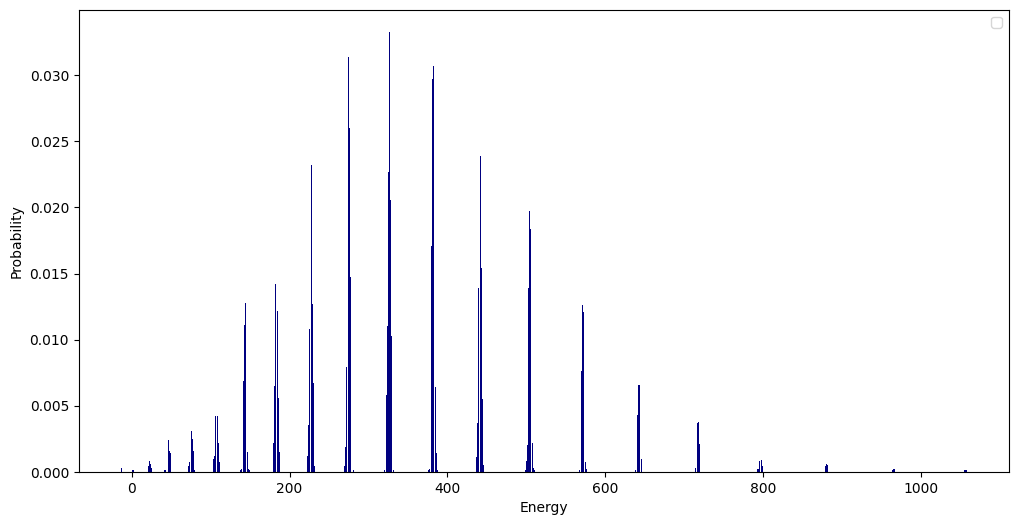

Unique energies: []
Accumulated probabilities: []


,Vacancies,Num_hits_avg,Num_hits_std,Num_hits_genuine_avg,Num_hits_genuine_std,QOS_avg,QOS_std,Validity_avg,Validity_std,Emb_Time_avg,...,b_chains_avg,b_chains_std,chain_length_avg,chain_length_std,Num_vars,Chain Strength,Anneal Time,Lambda,yerr (not %),yerr post-sel (not %)
0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,32,12,def,2,0.0,0.0


In [12]:
# Initialize lists to store results from multiple repetitions
num_hits_reps = []
num_hits_genuine_reps = []
QOS_reps = []
valid_reps = []
AR_reps = []
SAR_reps = []
SAR_exp_reps = []
Emb_time_reps = []
QPU_time_reps = []
QPU_acc_time_reps = []
Time_reps = []
b_chains_reps = []
min_E_reps = []
min_E_posel_reps = []
chain_reps = []

# Initialize lists to accumulate energy and probability data
energies_accum = []
probs_accum = []
energies_post_sel_accum = []
probs_post_sel_accum = []

# Loop over the number of repetitions
for j in range(repeats):
    num_vac = num_vacs[0]  # Number of vacancies
    lambda_1 = lambdas  # Regularization parameter

    # Define the size of the graphene supercell
    n_supercell = n_supercell  
    scaling_matrix = np.identity(3) * n_supercell
    scaling_matrix[2][2] = 1  # Preserve the c-axis (third dimension)
    graphene_supercell = copy.deepcopy(graphene)  # Create a deep copy of the graphene structure
    graphene_supercell.make_supercell(scaling_matrix)  # Expand the graphene unit cell
    structure = graphene_supercell  # Store the modified graphene structure

    # Generate the QUBO problem from the supercell structure
    Q = build_qubo_vacancies(graphene_supercell, num_vac=num_vac, coord_obj=False, lambda_1=lambda_1, beta=0)
    num_vars = Q.shape[0]  # Number of variables in the QUBO matrix


    start = timeit.default_timer() # Start the timer
    
    # Select quantum or classical sampler based on the device
    if device == 'QA':  # Quantum Annealer
        if embedding ==  'minor':
            connection = DWaveSampler(solver='Advantage_system6.4',annealing_time=anneal_time,token="=")
            sampler = EmbeddingComposite(connection) 
        if embedding ==  'clique':
            sampler = DWaveCliqueSampler(solver='Advantage_system6.4',use_cache=False,annealing_time=anneal_time,token="=") 
    if device == 'Hybrid': # Hybrid quantum-classical solver
        anneal_time = 'def'
        sampler = LeapHybridSampler(token="=")
    if device == 'SA': # Simulated Annealing
        anneal_time = 'def'
        sampler = SimulatedAnnealingSampler() 
    if device == 'Random':
        anneal_time = 'def'
        sampler = RandomSampler()

    
    print('Embedding took:', TimeEmbed)
    Emb_time_reps.append(TimeEmbed)  # Store embedding time

    startQPUish = timeit.default_timer()  # Start timing QPU execution
    
    # Execute the QUBO on the selected sampler
    if device == 'QA':
        sampleset = sampler.sample_qubo(Q, num_reads=shots,
                                        label=f'Graphene {n_supercell}x{n_supercell} {num_vac} vacancies',
                                        chain_strength=chain_strength_value)
    elif device == 'Hybrid':
        sampleset = sampler.sample_qubo(Q, label=f'Graphene {n_supercell}x{n_supercell} {num_vac} vacancies')
    elif device == 'SA':
        sampleset = sampler.sample_qubo(Q, num_reads=1000, beta_range=beta_range, num_sweeps=num_sweeps,
                                        label=f'Graphene {n_supercell}x{n_supercell} {num_vac} vacancies')
    elif device == 'Random':
        sampleset = sampler.sample_qubo(Q, num_reads=1000,
                                        label=f'Graphene {n_supercell}x{n_supercell} {num_vac} vacancies')

    # If using the clique embedding, calculate average chain length
    if device == 'QA' and embedding == 'clique':
        embed = sampleset.info['embedding_context']['embedding']
        total_length = sum(len(chain) for chain in embed.values())
        average_chain_length = total_length / len(embed)
        chain_reps.append(average_chain_length)

    stop = timeit.default_timer()  # Stop overall timing
    stopQPUish = timeit.default_timer()  # Stop QPU timing
    QPUtime = stopQPUish - startQPUish
    QPU_time_reps.append(QPUtime)
    Time = stop - start
    Time_reps.append(Time)
    

    # Assign theoretical minimum energy based on known problem instances
    min_E_theor = -20 if (n_supercell == 3 and num_vac == 3) else -5 if (n_supercell == 2 and num_vac == 3) else -41 if (n_supercell == 4 and num_vac == 3) else -68 if (n_supercell == 5 and num_vac == 3) else -101 if (n_supercell == 6 and num_vac == 3) else -140 if (n_supercell == 7 and num_vac == 3) else -20

    min_E = min_E_theor
    
    # Extract QPU access time if applicable
    if device == 'Hybrid':
        QPU_acc_time = sampleset.info["qpu_access_time"] / 1e6
    elif device == 'QA':
        QPU_acc_time = sampleset.info["timing"]["qpu_access_time"] / 1e6
        QPU_acc_time_reps.append(QPU_acc_time)
    
    df = sampleset.to_pandas_dataframe()  # Convert results to Pandas DataFrame

    # Save raw data to CSV file
    if device == 'QA':
        path = f'RawResults/preprepro_{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_{timestr}_rep{j}.csv'
    else:
        path = f'RawResults/preprepro_{device}_nsuper{n_supercell}_nV{num_vac}_{timestr}_rep{j}.csv'
    # Save the DataFrame to a CSV file
    df.to_csv(path, index=False, float_format='%.15g')

    
    # Process DataFrame: remove duplicates, normalize occurrence probabilities, and sort by energy
    df = df.groupby(df.columns[:-1].tolist(), as_index=False)['num_occurrences'].sum()
    if device=='Hybrid':
        df['Valid % Occurence'] = df['num_occurrences']*100
    else:
        df['Valid % Occurence'] = df['num_occurrences'].apply(lambda x: (x/1000)*100)
    df['energy'] = df['energy'].apply(lambda x: x+lambda_1*(Q.shape[0]-num_vac)**2)
    df = df.sort_values(by="Valid % Occurence", ascending=False)

    # Compute minimum energy found in the dataset
    best_min_E_inDF = df['energy'].min()

    # Calculate weighted energy
    df['Weighted Energy'] = df['energy'] * (df['Valid % Occurence'] / 100)
    # Calculate average energy
    avg_E = df['Weighted Energy'].sum()
        
    # Save df here pre-pro
    if device == 'QA':
        path = f'RawResults/prepro_{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_{timestr}_rep{j}.csv'
    else:  
        path = f'RawResults/prepro_{device}_nsuper{n_supercell}_nV{num_vac}_{timestr}_rep{j}.csv'
    # Save the DataFrame to a CSV file
    df.to_csv(path, index=False, float_format='%.15g')

    energies_accum.append(np.asarray(df['energy']))
    probs_accum.append(np.asarray(df['Valid % Occurence'])/100)
    
    ### Num hits is just the df['% Occurence'] summed for the minimum energies
    dfhits = df[df['energy'] == min_E]
    num_hits = dfhits['Valid % Occurence'].sum()


    starT = timeit.default_timer()
    
    # Post-selection
    # Count the number of zeros in columns 0 to Q
    num_zeros = df.iloc[:, :Q.shape[0]].eq(0).sum(axis=1)
    # Keep only the rows with exactly three zeros
    df = df[num_zeros == num_vac]
    valid = df['Valid % Occurence'].sum()

    # Calculate Ps
    dfhits_genuine = df[df['energy'] == min_E]
    best_min_E_inDF_posel = df['energy'].min()
    num_hits_genuine = dfhits_genuine['Valid % Occurence'].sum()
    
    # Now find Ps (QOS) after post selection
    # Step 1: Calculate the total sum of the '% Occurrence' column
    total_sum = df['Valid % Occurence'].sum()
    # Step 2: Divide each value in the '% Occurrence' column by the total sum
    df['% Occurence'] = df['Valid % Occurence'] / total_sum
    # Step 3: Multiply each value by 100
    df['% Occurence'] = df['% Occurence'] * 100

     # Calculate weighted energy
    df['Weighted Energy'] = df['energy'] * (df['% Occurence'] / 100)
    # Calculate average energy
    avg_E = df['Weighted Energy'].sum()
    print(avg_E)

    max_E_postsel = df['energy'].max()
    
    print('Max energy post-selection:',max_E_postsel)

    # Note max_E_postsel will coincide with max_E from brute force (constrained)
    AR = (avg_E-max_E_postsel)/(min_E_theor-max_E_postsel)

    energies_post_sel_accum.append(np.asarray(df['energy']))
    probs_post_sel_accum.append(np.asarray(df['% Occurence'])/100) # Renormalised % occurence
    
    # Save df here post-pro
    if device == 'QA':
        path = f'RawResults/postpro_{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_{timestr}_rep{j}.csv'
    else:  
        path = f'RawResults/postpro_{device}_nsuper{n_supercell}_nV{num_vac}_{timestr}_rep{j}.csv'
    
    # Save the DataFrame to a CSV file
    df.to_csv(path, index=False, float_format='%.15g')
    
    # Filter the DataFrame to include only rows with the minimum energy value
    good_df = df[df['energy'] == min_E]
    QOS = good_df['% Occurence'].sum()

    # Stop timer
    stoP = timeit.default_timer()
    timE = stoP - starT

    num_hits_reps.append(num_hits)
    num_hits_genuine_reps.append(num_hits_genuine)
    QOS_reps.append(QOS)
    valid_reps.append(valid)
    AR_reps.append(AR)
    min_E_reps.append(best_min_E_inDF)
    min_E_posel_reps.append(best_min_E_inDF_posel)
    
    if device == 'QA':
        b_chains = df['chain_break_fraction'].values
        b_chains_reps.append(np.average(b_chains))

    
    if j == (repeats-1):
        num_hits_avg = np.average(num_hits_reps)
        num_hits_genuine_avg = np.average(num_hits_genuine_reps)
        QOS_avg = np.average(QOS_reps)
        valid_avg = np.average(valid_reps)
        b_chains_avg = np.average(b_chains_reps)
        AR_avg = np.average(AR_reps)
        min_E_avg = np.average(min_E_reps)
        min_E_posel_avg = np.average(min_E_posel_reps)

        num_hits_std = np.std(num_hits_reps)
        num_hits_genuine_std = np.std(num_hits_genuine_reps)
        QOS_std = np.std(QOS_reps)
        valid_std = np.std(valid_reps)

        AR_std = np.std(AR_reps)
        min_E_std = np.std(min_E_reps)
        min_E_posel_std = np.std(min_E_posel_reps)
        b_chains_std = np.std(b_chains_reps)
        emb_time_avg = np.average(Emb_time_reps)
        emb_time_std = np.std(Emb_time_reps)
        QPU_time_avg = np.average(QPU_time_reps)
        QPU_time_std = np.std(QPU_time_reps)
        QPU_acc_time_avg = np.average(QPU_acc_time_reps)
        QPU_acc_time_std = np.std(QPU_acc_time_reps)
        Time_avg = np.average(Time_reps)
        Time_std = np.std(Time_reps)
        chain_length_avg = np.average(chain_reps)
        chain_length_std = np.std(chain_reps)
    
        FINALdf = pd.DataFrame({
            'Vacancies': [num_vac],
            'Num_hits_avg' : [num_hits_avg],
            'Num_hits_std' : [num_hits_std],
            'Num_hits_genuine_avg' : [num_hits_genuine_avg],
            'Num_hits_genuine_std' : [num_hits_genuine_std],
            'QOS_avg': [QOS_avg],
            'QOS_std': [QOS_std],
            'Validity_avg': [valid_avg],
            'Validity_std': [valid_std],
            'Emb_Time_avg': [emb_time_avg],
            'Emb_Time_std': [emb_time_std],
            'QPU_Acc_Time_avg': [QPU_acc_time_avg],
            'QPU_Acc_Time_std': [QPU_acc_time_std],
            'QPU_Time_avg': [QPU_time_avg],
            'QPU_Time_std': [QPU_time_std],
            'Time_avg': [Time_avg],
            'Time_std': [Time_std],
            'AR_avg':[AR_avg],
            'AR_std':[AR_std],
            'min energy':[min_E_reps],
            'min energy probs (num hits)':[num_hits_reps],
            'min energy avg': [min_E_avg],
            'min energy std': [min_E_std],
            'min energy post-sel':[min_E_posel_reps],
            'min energy avg post-sel': [min_E_posel_avg],
            'min energy post-sel std': [min_E_posel_std],
            'nsuper' : [n_supercell],
            'b_chains_avg': [b_chains_avg],
            'b_chains_std': [b_chains_std],
            'chain_length_avg': [chain_length_avg],
            'chain_length_std': [chain_length_std],
            'Num_vars':[num_vars],
            'Chain Strength':[chain_strength_value],
            'Anneal Time':[anneal_time],
            'Lambda':[lambdas]
        })

        # yerr
        y = FINALdf['Num_hits_genuine_avg'].values/100
        yerr = 2 * np.sqrt((y * (1-y)) / (shots*repeats+1))
        FINALdf['yerr (not %)'] = yerr
        
        y = FINALdf['QOS_avg'].values/100
        yerr_postsel = 2 * np.sqrt((y * (1-y)) / (shots*repeats+1))
        FINALdf['yerr post-sel (not %)'] = yerr_postsel

        ############ Plot distributions pre post selection
        # Flatten lists if necessary
        energies_accum_flat = np.concatenate(energies_accum)  # Concatenate lists into a single array
        probs_accum_flat = np.concatenate(probs_accum) / repeats  # Concatenate lists into a single array

        
        # Accumulate probabilities for each unique energy
        accumulated_probs = {}
        for energy, prob in zip(energies_accum_flat, probs_accum_flat):
            if energy in accumulated_probs:
                accumulated_probs[energy] += prob
            else:
                accumulated_probs[energy] = prob
        
        # Extract unique energies and accumulated probabilities
        unique_energies = np.array(list(accumulated_probs.keys()))
        unique_probs = np.array(list(accumulated_probs.values()))
        
        # Print results for verification
        print("Unique energies:", unique_energies)
        print("Accumulated probabilities:", unique_probs)
        ###################
        if device =='QA':
            np.savetxt(f'distr_data/Energy_data_prepro_{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.txt', unique_energies, fmt='%.10f')
            np.savetxt(f'distr_data/Probs_data_prepro_{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.txt', unique_probs, fmt='%.10f')
        else:
            np.savetxt(f'distr_data/Energy_data_prepro_{device}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.txt', unique_energies, fmt='%.10f')
            np.savetxt(f'distr_data/Probs_data_prepro_{device}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.txt', unique_probs, fmt='%.10f')


        # Make final accumulated plot
        plt.figure(figsize=(12, 6))
        plt.bar(unique_energies, unique_probs, color='navy')
        # plt.axvline(x=min_E_avg, color='r', linestyle='--', label="Min QUBO Energy")
        plt.legend(loc="upper right")
        plt.xlabel('Energy')
        plt.ylabel('Probability')
        # plt.title('Probability vs. fval')

        print('QOS is num_hits post-selection')

        if device=='QA':
            plt.savefig(f'annealing_plots/Energy_data_prepro_{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.pdf', format='pdf', bbox_inches='tight')
        else:
            plt.savefig(f'annealing_plots/Energy_data_prepro_{device}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.pdf', format='pdf', bbox_inches='tight')
        plt.show()

        # Post processing
        energies_accum_flat = np.concatenate(energies_post_sel_accum)  # Concatenate lists into a single array
        probs_accum_flat = np.concatenate(probs_post_sel_accum) / repeats  # Concatenate lists into a single array

        # Accumulate probabilities for each unique energy
        accumulated_probs = {}
        for energy, prob in zip(energies_accum_flat, probs_accum_flat):
            if energy in accumulated_probs:
                accumulated_probs[energy] += prob
            else:
                accumulated_probs[energy] = prob
        
        # Extract unique energies and accumulated probabilities
        unique_energies = np.array(list(accumulated_probs.keys()))
        unique_probs = np.array(list(accumulated_probs.values()))
        
        # Print results for verification
        print("Unique energies:", unique_energies)
        print("Accumulated probabilities:", unique_probs)
        ###################
        
        if device=='QA':
            np.savetxt(f'distr_data/Energy_data_postpro_{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.txt', unique_energies, fmt='%.10f')
            np.savetxt(f'distr_data/Probs_data_postpro_{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.txt', unique_probs, fmt='%.10f')
        else:
            np.savetxt(f'distr_data/Energy_data_postpro_{device}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.txt', unique_energies, fmt='%.10f')
            np.savetxt(f'distr_data/Probs_data_postpro_{device}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_chain{chain_strength_value}_at{anneal_time}.txt', unique_probs, fmt='%.10f')

        
        # Display Dataframe
        display(FINALdf)
    
        # Now save as dataframe
        # Define the path for saving the CSV file
        if device=='QA':
            path = f'final_CSVs/{device}_{embedding}_nsuper{n_supercell}_nV{num_vac}_chain{chain_strength_value}_l{lambdas}_at{anneal_time}.csv'
        elif device =='SA':
            path = f'final_CSVs/{device}_nsuper{n_supercell}_nV{num_vac}_l{lambdas}_b{beta_range}_numsweep{num_sweeps}.csv'
        else:
            path = f'final_CSVs/{device}_nsuper{n_supercell}_nV{num_vac}_chain{chain_strength_value}_l{lambdas}_at{anneal_time}.csv'
        
        # Save the DataFrame to a CSV file
        FINALdf.to_csv(path, index=False, float_format='%.15g')

        
    else:
        continue

In [8]:
# sampleset.info["timing"]["qpu_access_time"]/1e6

# display(df)

# dwave.inspector.show(sampleset)

# sampleset.info